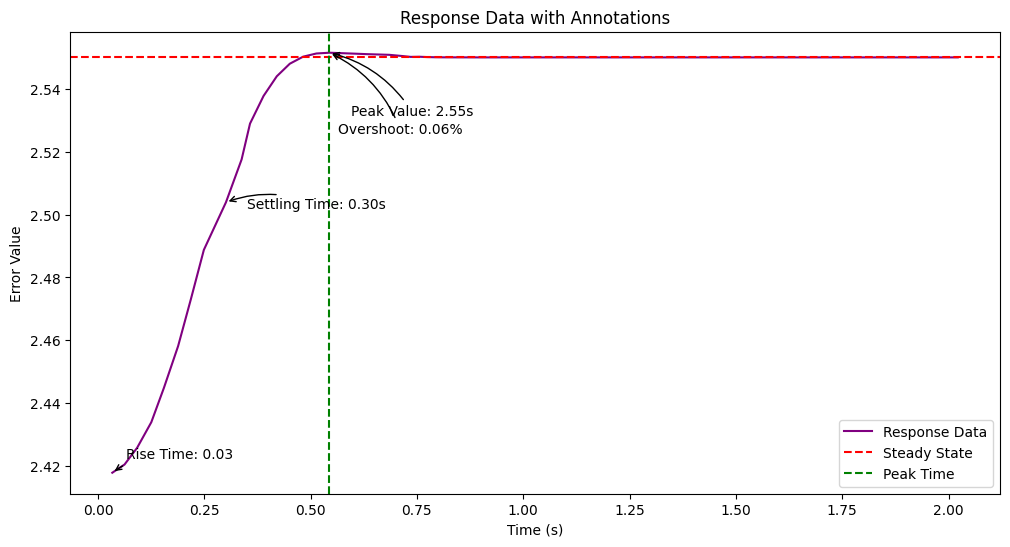

Steady State Value: 2.55
Peak Time: 0.54
Peak Value: 2.55
Overshoot (%): 0.06
Rise Time: 0.03
Settling Time: 0.30
Undershoot (%): None


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import numpy as np
# Nama file CSV yang akan dibaca
csv_file_name = 'data_simulasi.csv'

# Baca data dari file CSV menggunakan pandas
data = pd.read_csv(csv_file_name)

sigma = 5 #filter gausian
smoothed_speed_data = gaussian_filter1d(data['ErrorValue'], sigma)

time = data['Time'].values
response = smoothed_speed_data  # Ganti 'SensorValue' dengan nama kolom data respons Anda


def annotate_plot(ax, time, data, text):
    for t, d in zip(time, data):
        ax.annotate(text, xy=(t, d), xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))


def plot_data_with_annotations(time, response):
    global steady_state_value, peak_time, peak_value, overshoot, rise_time, settling_time, undershoot
    response = np.abs(response)

    fig, ax = plt.subplots(figsize=(12,6))

    
    ax.plot(time, response, label='Response Data', color='purple')

    steady_state_value = np.mean(response[-10:])
    ax.axhline(y=steady_state_value, color='r', linestyle='--', label='Steady State')

    peaks, _ = find_peaks(response)
    peak_time = time[peaks][0] if peaks.size > 0 else None
    if peak_time is not None:
        ax.axvline(x=peak_time, color='g', linestyle='--', label='Peak Time')

    if peak_time is not None:
        peak_value = response[peaks][0]
        # annotate_plot(ax, [peak_time], [peak_value], f'Peak Value: {peak_value:.2f}')
        peakValue_text = f'Peak Value: {peak_value:.2f}s'
        ax.annotate(peakValue_text, xy=(peak_time, peak_value), xytext=(peak_time + 0.05, peak_value - 0.02),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    rise_time_index = np.where(response >= 0.9 * steady_state_value)[0][0] if np.any(response >= 0.9 * steady_state_value) else None
    if rise_time_index is not None:
        rise_time = time[rise_time_index]
        annotate_plot(ax, [rise_time], [response[rise_time_index]], f'Rise Time: {rise_time:.2f}')

    settling_index = np.where(np.abs(response - steady_state_value) <= 0.02 * steady_state_value)[0]
    settling_time = time[settling_index[0]] if settling_index.size > 0 else None
    if settling_time:
        # annotate_plot(ax, [settling_time], [response[settling_index[0]]], f'Settling Time: {settling_time:.2f}')
        settlingTime_text = f'Settling Time: {settling_time:.2f}s'
        ax.annotate(settlingTime_text, xy=(settling_time, response[settling_index[0]]), xytext=(settling_time + 0.05, response[settling_index[0]] - 0.002),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))


    overshoot = ((peak_value - steady_state_value) / steady_state_value) * 100 if peak_value is not None else None
    if overshoot is not None:
        overshoot_text = f'Overshoot: {overshoot:.2f}%'
        ax.annotate(overshoot_text, xy=(peak_time, peak_value), xytext=(peak_time + 0.02, peak_value - 0.0258),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    undershoot = None
    if np.any(response < 0):
        undershoot_value = np.min(response)
        undershoot = ((steady_state_value - undershoot_value) / steady_state_value) * 100 if undershoot_value is not None else None
    if undershoot is not None:
        annotate_plot(ax, [peak_time], [peak_value], f'Undershoot: {undershoot:.2f}%')

    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Error Value')
    ax.set_title('Response Data with Annotations')
    ax.grid(False)

    # Membalik sumbu y jika ada nilai negatif
    if np.any(response < 0):
        ax.set_ylim(ax.get_ylim()[::-1])

    plt.show()
    return {
        'Steady State Value': steady_state_value,
        'Peak Time': peak_time,
        'Peak Value': peak_value,
        'Overshoot (%)': overshoot,
        'Rise Time': rise_time,
        'Settling Time': settling_time,
        'Undershoot (%)': undershoot
    }
# Jalankan fungsi plot dan cetak metrik
metrics = plot_data_with_annotations(time, response)
if metrics:
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: None")